In [1]:
import pickle
import numpy as np
import networkx as nx
import time
import scipy.stats as stat

N = 1000 # 1000 data points in this training set
k = 10 # Each node in the graph will have edges to its 10 nearest neighbors
S = 50 # need S-nn graph for soft label empirical distribution over S nearest neighbors, S >> k
M = 4 # partition this into 4 parts
num_points = 8 # each example has 8 points
num_features_per_point = 2 # each point has 2 features

folder = '../data/balanced_toy/'

### Model Setup

In [2]:
# load the training data
points = pickle.load(open(folder + 'points.pickle', 'rb'))
assert len(points) == N
distances = pickle.load(open(folder + 'distances.pickle', 'rb'))

In [3]:
def total_distance(med, cluster):
    total = 0
    for i in cluster:
        total += distances[i, med]
    return total

def calculate_medoids_for_partition(partition):
    partition_copy = [list(part) for part in partition]
    medoids = [part[0] for part in partition_copy]
    
    for i in range(len(medoids)):
        for new_med in partition_copy[i][1:]:
            if total_distance(new_med, partition[i]) < total_distance(medoids[i], partition[i]):
                medoids[i] = new_med
    return medoids

In [4]:
# import the knn graph and partitions
G = nx.read_gpickle(folder + 'knn_graph.gpickle')

# partition_by_component = True
# if partition_by_component:
#     partitions = [set(range(250)), set(range(250, 500)), set(range(500, 750)), set(range(750,1000))]
# else:
#     partitions = nx.read_gpickle(folder + 'graph_partitions.pickle')
graph_partition = nx.read_gpickle(folder + 'graph_partitions.pickle')
km_partition = nx.read_gpickle(folder + 'km_partitions.pickle')

graph_medoids = calculate_medoids_for_partition(graph_partition)
km_medoids = pickle.load(open(folder + 'medoids.pickle', 'rb'))

assert N == len(G.nodes())
assert M == len(graph_partition)
assert M == len(km_partition)
levels = int(np.log2(M))
assert M == 2 ** levels

In [5]:
def get_flat_X_unsorted(points):
    # flatten each training point's feature matrix into a single feature vector
    # note that not every collision event may have the same number of particles
    num_particles = 0
    for point in points:
        num_particles = max(num_particles, point.shape[0])
    num_readings = points[0].shape[1] # every particle should have the same number (3) of readigns

    X = []
    for point in points:
        feature = np.copy(point)
        feature.resize((num_particles * num_readings, ))
        X.append(feature)
    return np.array(X)

def get_flat_X_sorted(points):
    # flatten each training point's feature matrix into a single feature vector
    # note that not every collision event may have the same number of particles
    num_particles = 0
    for point in points:
        num_particles = max(num_particles, point.shape[0])
    num_readings = points[0].shape[1] # every particle should have the same number (3) of readigns

    X = []
    for point in points:
        feature = np.copy(point)
        
        # sort the point data by the first column
        index = feature[:,0].argsort()
        feature = feature[index]
        
        # now flatten the feature and fill in with 0's
        feature.resize((num_particles * num_readings, ))
        X.append(feature)
    return np.array(X)

def get_mean_X(points):
    # take mean of column across all points to create the feature
    X = []
    for point in points:
        feature = np.mean(point, axis=0)
        X.append(feature)
    return np.array(X)

def get_moments_X(points, num_moments=5):
    # take mean of column across all points to create the feature
    X = []
    for point in points:
        feature = np.mean(point, axis=0)
        for i in range(2, 2 + num_moments):
            feature = np.append(feature, stat.moment(point, i, axis=0))
        X.append(feature)
    return np.array(X)
    
def get_class_labels(partition):
#     if partition_by_component:
#         labels = []
#         for i in range(250):
#             labels.append(0)
#         for i in range(250, 500):
#             labels.append(1)
#         for i in range(500, 750):
#             labels.append(2)
#         for i in range(750, 1000):
#             labels.append(3)
#         return np.array(labels)
#     else:
    # create labels for each node
    labels_dict = {}
    for i, part in enumerate(partition):
        for node in part:
            labels_dict[node] = i

    labels = []
    for i in range(N):
        labels.append(labels_dict[i])
    return np.array(labels)

def get_hierarchical_labels(labels):
    # return vector of 0 and 1's where each entry determines next splitting point    
    Y = []
    for label in labels:
        hierarchical_label = []
        for j in range(levels):
            hierarchical_label.append(label // (2 ** (levels - 1 - j)))
            label = label % (2 ** (levels - 1 - j))
        Y.append(hierarchical_label)
    return np.array(Y)

def get_soft_labels(labels):
    # turn the labels into soft labels
    # for this, the label becomes the empirical distribution of the part that each node's S nearest neighbors belong to
    nns = nx.read_gpickle(folder + 'nearest_neighbors.pickle')
    Y = []
    for i in range(N):
        distribution = np.zeros(M)
        for n in nns[i]:
            distribution[labels[n]] += 1
        distribution = np.divide(distribution, np.sum(distribution))
        Y.append(distribution)
    Y = np.array(Y)

    return Y

In [6]:
# Sorted Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

def lr_train_hierarchical(models, prefix, X, y, level):
    if level == levels:
        return
    
    clf = LogisticRegression(solver='lbfgs').fit(X, y[:,level])
    models[prefix] = clf
    
    predictions = clf.predict(X)
    all_zeros = np.zeros(len(predictions))
    X_left = X[predictions == all_zeros]
    y_left = y[predictions == all_zeros]
    print(len(X_left))
    lr_train_hierarchical(models, prefix + '0', X_left, y_left, level + 1)
    
    all_ones = np.ones(len(predictions))
    X_right = X[predictions == all_ones]
    y_right = y[predictions == all_ones]
    print(len(X_right))
    lr_train_hierarchical(models, prefix + '1', X_right, y_right, level + 1)

def lr_predict(model, x, num_levels=levels):
    prediction = []
    prefix = ''
    while len(prefix) < num_levels:
        clf = model[prefix]
        label = clf.predict(x)[0]
        prefix += str(label)
        prediction.append(label)
    return np.array(prediction)
    
def lr_prediction_accuracy(model, X, y):
    num_levels = levels # how deep in the tree to check
    num_correct = 0
    
    # check each data point
    for i in range(len(X)):
        x = X[i:i+1,:]
        prediction = lr_predict(model, x, num_levels)
                
        if (y[i][:num_levels] == prediction).all():
            num_correct += 1
    
    return num_correct / len(X)

def lr_predict_best_partition(model, x):
    return np.dot(np.power(2, range(levels)[::-1]), lr_predict(model, x))

In [7]:
# K-Medoids Classifier code
import ot

def ot_distance(x, y):
    x = x.reshape(-1, num_features_per_point)
    y = y.reshape(-1, num_features_per_point)
    C = ot.dist(x, y)
    return ot.emd2([], [], C)

def km_predict_best_partition(medoids, x):
    best = 0
    distance = ot_distance(x, points[medoids[best]])
    for i in range(1, len(medoids)):
        new_distance = ot_distance(x, points[medoids[i]])
        if new_distance < distance:
            distance = new_distance
            best = i
    return best

def km_prediction_accuracy(medoids, X, y):
    num_correct = 0
    
    # check each data point
    for i in range(len(X)):
        x = X[i:i+1,:]
        prediction = km_predict_best_partition(medoids, x)
        if prediction == y[i]:     
            num_correct += 1
    
    return num_correct / len(X)

### t-SNE

### Experiments - KL Partitions

In [8]:
partition = graph_partition
medoids = graph_medoids

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

labels = get_class_labels(partition).reshape(-1, 1)
#labels = enc.fit_transform(labels)
train_points, test_points, train_labels, test_labels = train_test_split(points, labels, test_size=0.2, random_state=42)

# load unseen points for evaluation
query_points = pickle.load(open(folder + 'test_points.pickle', 'rb'))

In [30]:
# Unsorted Linear Regression Training
lr_unsorted_model = {}

X_train = get_flat_X_unsorted(train_points)
y_train = train_labels
X_test = get_flat_X_unsorted(test_points)
y_test = test_labels

clf = LogisticRegression()
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))


# now assess test accuracy
#print(lr_prediction_accuracy(lr_unsorted_model, X_test, y_test))

1.0


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [11]:
# Sorted Linear Regression Training
lr_sorted_model = {}

X_train = get_flat_X_sorted(train_points)
y_train = get_hierarchical_labels(train_labels)
X_test = get_flat_X_sorted(test_points)
y_test = get_hierarchical_labels(test_labels)

lr_train_hierarchical(lr_sorted_model, "", X_train, y_train, 0)

# now assess test accuracy
print(lr_prediction_accuracy(lr_sorted_model, X_test, y_test))

437
211
226
363
188
175
0.535


In [66]:
# Mean Linear Regression Training
lr_mean_model = {}

X_train = get_mean_X(train_points)
print(X_train)
print(y_train)
y_train = get_hierarchical_labels(train_labels)
X_test = get_mean_X(test_points)
y_test = get_hierarchical_labels(test_labels)

lr_train_hierarchical(lr_mean_model, "", X_train, y_train, 0)

# now assess test accuracy
print(lr_prediction_accuracy(lr_mean_model, X_test, y_test))

[[ 2.4945217   1.55755534]
 [ 2.77978261 -2.6505893 ]
 [ 2.51275569 -2.83628117]
 ...
 [-2.98996771 -2.47344915]
 [-2.35863521  2.47039083]
 [ 1.8071044   2.23319382]]
[[0 1]
 [1 1]
 [1 1]
 ...
 [0 0]
 [1 0]
 [0 1]]
800
399
401
0


ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

In [62]:
# Moment Linear Regression Training
lr_moment_model = {}

X_train = get_moments_X(train_points)
y_train = get_hierarchical_labels(train_labels)
X_test = get_moments_X(test_points)
y_test = get_hierarchical_labels(test_labels)

lr_train_hierarchical(lr_moment_model, "", X_train, y_train, 0)

# now assess test accuracy
print(lr_prediction_accuracy(lr_moment_model, X_test, y_test))

0.455


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [14]:
# Assess test accuracy for K-Mediods
print(km_prediction_accuracy(medoids, test_points, test_labels))

0.071
0.05


In [15]:
# Ground Truth
knn_real = []
t1 = time.time()
for i in range(len(query_points)):
    x = query_points[i]
    distances = []
    for node_id in range(N):
        d = ot_distance(x, points[node_id])
        distances.append((node_id, d))
    distances.sort(key=lambda x: x[1])
    knn_real.append([u[0] for u in distances[:k]])
t2 = time.time()

print('Time: {}'.format(t2-t1))

Time: 62.021178007125854


In [16]:
# Model Evaluation
for model in [('Log Reg Sorted', lr_predict_best_partition, lr_sorted_model), 
              ('K-Medoids', km_predict_best_partition, medoids)]:
    print('Model: {}'.format(model[0]))
    
    knn_sample = []
    t1 = time.time()
    for i in range(len(X_query)):
        x = X_query[i:i+1, :]
        label = model[1](model[2], x)
        assigned_partition = partition[label]

        distances = []
        for node_id in assigned_partition:
            d = ot_distance(x, X[node_id:node_id+1, :])
            distances.append((node_id, d))
        distances.sort(key=lambda x: x[1])
        knn_sample.append([u[0] for u in distances[:k]])
    t2 = time.time()
    
    print('Time: {}'.format(t2-t1))
    
    # evaluate accuracy
    percents_captured = []
    for i in range(len(knn_sample)):
        num_correct = len(np.intersect1d(knn_sample[i], knn_real[i]))
        percents_captured.append(num_correct / k)
    print('Average Accuracy/Recall: {}'.format(np.mean(percents_captured)))

Model: Log Reg Sorted
Time: 3.509425163269043
Average Accuracy/Recall: 0.0642857142857143
Model: K-Medoids
Time: 4.723416090011597
Average Accuracy/Recall: 0.075


### Other Stuff

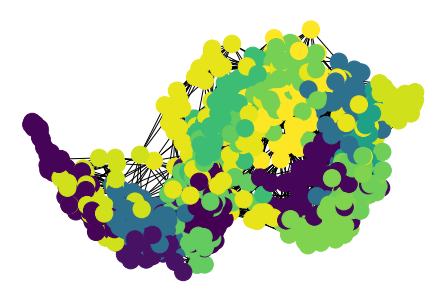

In [22]:
import matplotlib.pyplot as plt

labels = get_class_labels(partition)
color_map = []
# colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
colors = np.random.rand(M,1)[:,0]

for i in range(N):
    color_map.append(colors[labels[i]])

nx.draw(G, node_color = color_map)
plt.show()

### Experiments - KM Partitions

In [23]:
partition = km_partition
medoids = km_medoids

In [24]:
X = get_flat_X_sorted(points)
y = get_class_labels(partition)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_lr_train = get_hierarchical_labels(y_train)
y_lr_test = get_hierarchical_labels(y_test)

# load unseen points for evaluation
X_query = get_flat_X_sorted(pickle.load(open(folder + 'test_points.pickle', 'rb')))

In [25]:
# Sorted Linear Regression Training
lr_sorted_model = {}
lr_train_hierarchical(lr_sorted_model, "", X_train, y_lr_train, 0)

# now assess test accuracy
print(lr_prediction_accuracy(lr_sorted_model, X_test, y_lr_test))

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWar

0.085


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [26]:
# Assess test accuracy for K-Mediods
print(km_prediction_accuracy(medoids, X, y))
print(km_prediction_accuracy(medoids, X_test, y_test))

0.088
0.055


In [27]:
# Ground Truth
knn_real = []
t1 = time.time()
for i in range(len(X_query)):
    x = X_query[i:i+1, :]
    distances = []
    for node_id in range(N):
        d = ot_distance(x, X[node_id:node_id+1, :])
        distances.append((node_id, d))
    distances.sort(key=lambda x: x[1])
    knn_real.append([u[0] for u in distances[:k]])
t2 = time.time()

print('Time: {}'.format(t2-t1))

Time: 55.72484302520752


In [28]:
# Model Evaluation
for model in [('Log Reg Sorted', lr_predict_best_partition, lr_sorted_model), 
              ('K-Medoids', km_predict_best_partition, medoids)]:
    print('Model: {}'.format(model[0]))
    
    knn_sample = []
    t1 = time.time()
    for i in range(len(X_query)):
        x = X_query[i:i+1, :]
        label = model[1](model[2], x)
        assigned_partition = partition[label]

        distances = []
        for node_id in assigned_partition:
            d = ot_distance(x, X[node_id:node_id+1, :])
            distances.append((node_id, d))
        distances.sort(key=lambda x: x[1])
        knn_sample.append([u[0] for u in distances[:k]])
    t2 = time.time()
    
    print('Time: {}'.format(t2-t1))
    
    # evaluate accuracy
    percents_captured = []
    for i in range(len(knn_sample)):
        num_correct = len(np.intersect1d(knn_sample[i], knn_real[i]))
        percents_captured.append(num_correct / k)
    print('Average Accuracy/Recall: {}'.format(np.mean(percents_captured)))

Model: Log Reg Sorted
Time: 3.371623992919922
Average Accuracy/Recall: 0.07857142857142858
Model: K-Medoids
Time: 4.132763862609863
Average Accuracy/Recall: 0.08214285714285716


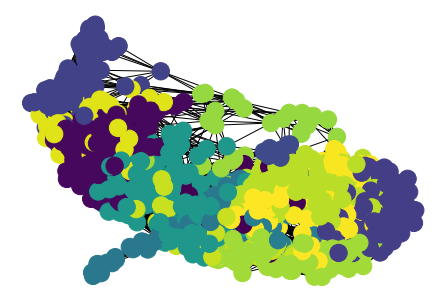

In [29]:
import matplotlib.pyplot as plt

labels = get_class_labels(partition)
color_map = []
# colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
colors = np.random.rand(M,1)[:,0]

for i in range(N):
    color_map.append(colors[labels[i]])

nx.draw(G, node_color = color_map)
plt.show()